In [87]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd

from graspy.plot import heatmap

from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr

from utils import estimate_block_assignment, to_distance_mtx, identity, sort_graph, block_permute, triu_no_diag

In [88]:
chem_file = '../../data/celegans/herm_chem_A_full_undirected.csv'
gap_file = '../../data/celegans/herm_gap_A_full_undirected.csv'
chem_cell_file = '../../data/celegans/herm_chem_full_cells.csv'
gap_cell_file = '../../data/celegans/herm_gap_full_cells.csv'

chem = pd.read_csv(chem_file, header=None).values
gap = pd.read_csv(gap_file, header=None).values
chem_cell = np.squeeze(pd.read_csv(chem_cell_file, header=None).values)
gap_cell = np.squeeze(pd.read_csv(gap_cell_file, header=None).values)

# take intersection
common_cell, chem_idx, gap_idx = np.intersect1d(chem_cell, gap_cell,
                                                return_indices=True)

#chem_idx = np.sort(chem_idx)
#gap_idx = np.sort(gap_idx)
chem = chem[np.ix_(chem_idx, chem_idx)]
gap = gap[np.ix_(gap_idx, gap_idx)]
chem_uw = np.where(chem > 0, 1, 0).astype(float)
gap_uw = np.where(gap > 0, 1, 0).astype(float)

In [89]:
chem.shape

(448, 448)

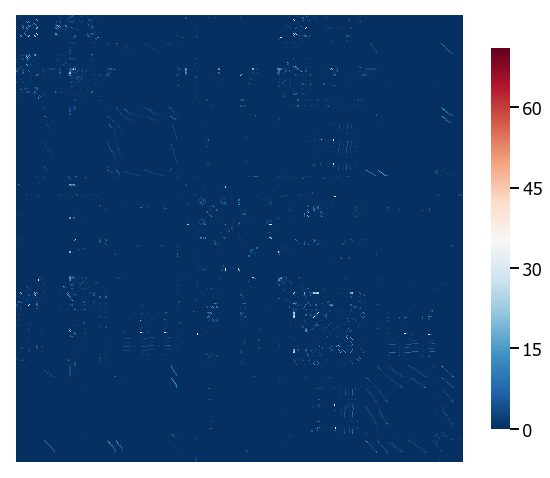

In [110]:
heatmap(chem, center=np.max(chem)/2)
plt.savefig('../../figures/celegans_chem_weighted.png', bbox_inches='tight')

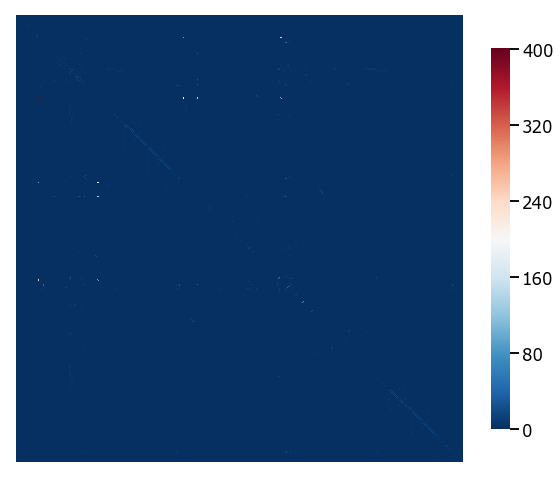

In [111]:
heatmap(gap, center=np.max(gap)/2)
plt.savefig('../../figures/celegans_gap_weighted.png', bbox_inches='tight')

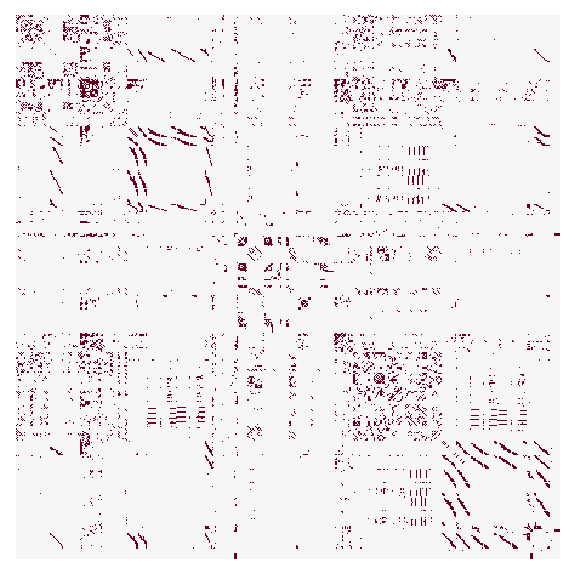

In [85]:
heatmap(chem_uw, cbar=False)
plt.savefig('../../figures/celegans_chem_unweighted.png', bbox_inches='tight')

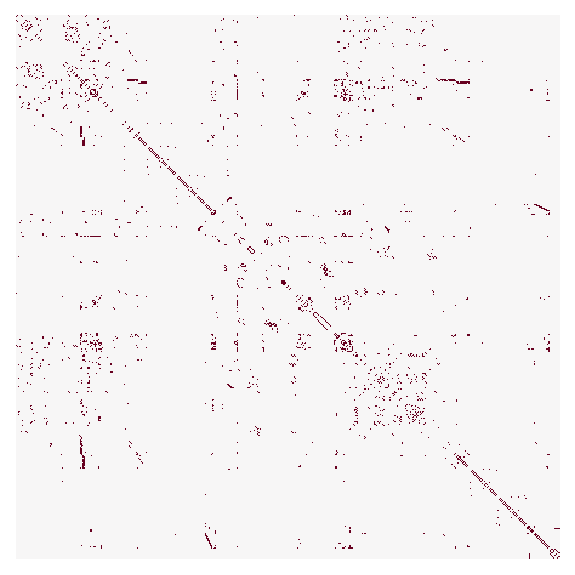

In [86]:
heatmap(gap_uw, cbar=False)
plt.savefig('../../figures/celegans_gap_unweighted.png', bbox_inches='tight')

In [35]:
block_assignment_uw = estimate_block_assignment(chem_uw, gap_uw, k=256, set_k=False, num_repeats=10)

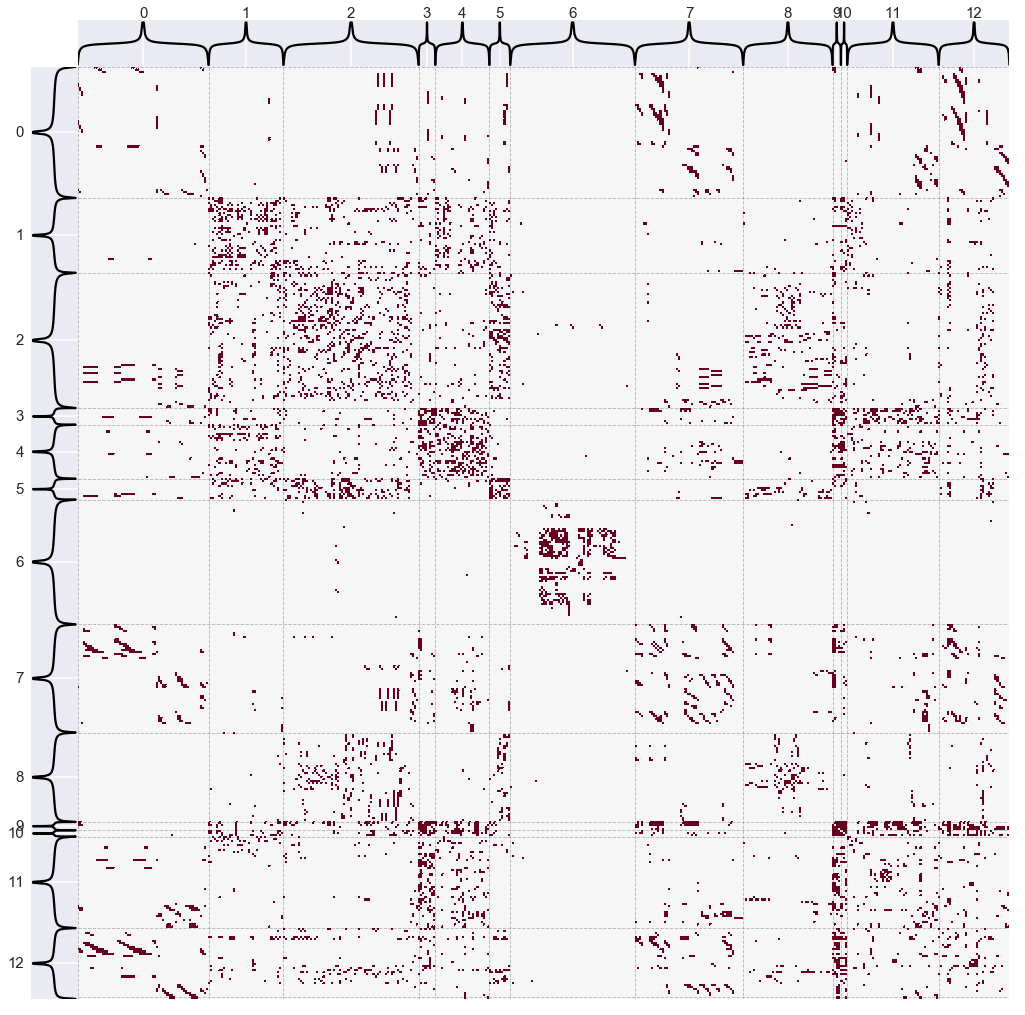

In [43]:
heatmap(chem_uw, inner_hier_labels=block_assignment_uw, cbar=False, figsize=(24, 18))
plt.savefig('../../figures/celegans_chem_unweighted_block.png', bbox_inches='tight')

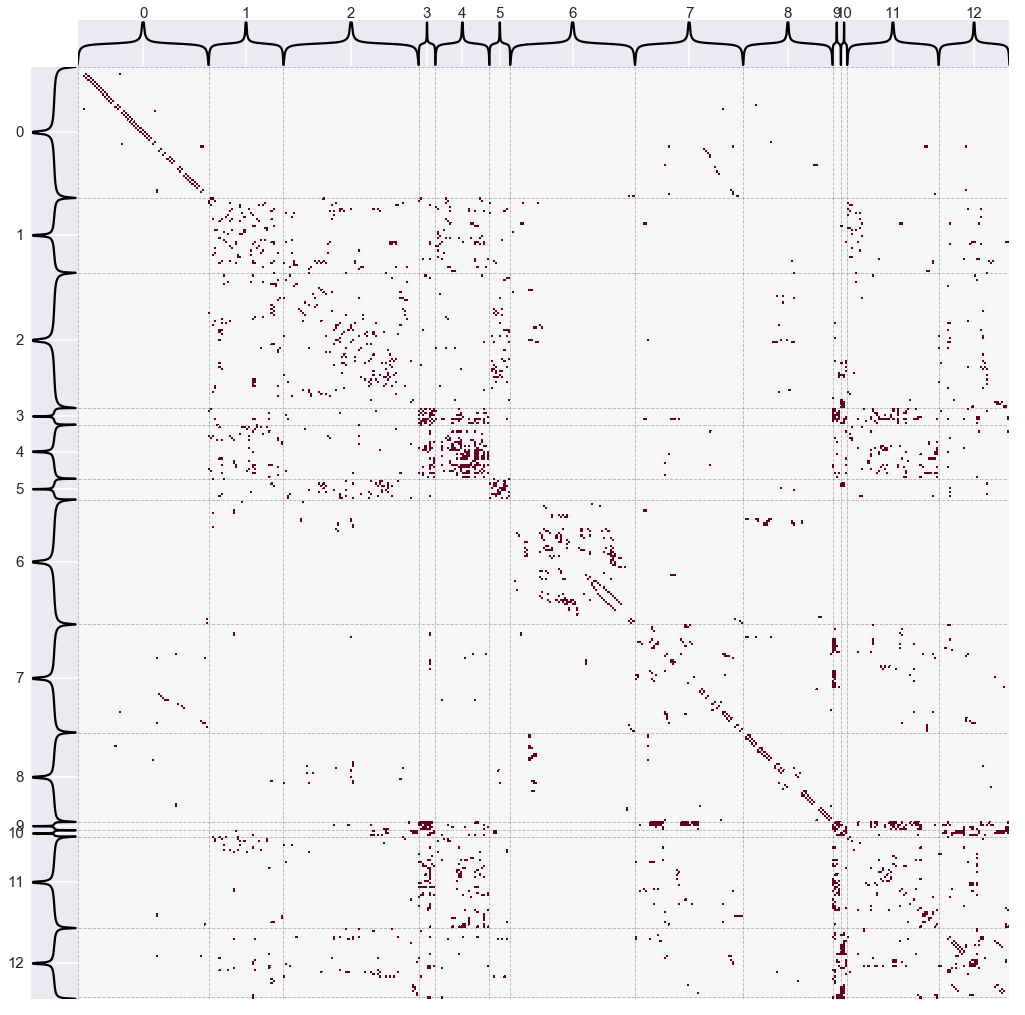

In [44]:
heatmap(gap_uw, inner_hier_labels=block_assignment_uw, cbar=False, figsize=(24, 18))
plt.savefig('../../figures/celegans_gap_unweighted_block.png', bbox_inches='tight')

In [92]:
def load_arr(test, weighted):
    if weighted:
        w = 'weighted'
    else:
        w = 'unweighted'
    if test == 'mgc':
        with open('../../results/celegans_chem_gap_{}_teststats_null_0.pkl'.format(w), 'rb') as f:
            null = pickle.load(f)
    elif test == 'dcorr':
        with open('../../results/celegans_chem_gap_{}_teststats_null_1.pkl'.format(w), 'rb') as f:
            null = pickle.load(f)
    elif test == 'pearson':
        with open('../../results/celegans_chem_gap_{}_teststats_null_2.pkl'.format(w), 'rb') as f:
            null = pickle.load(f)

    null = dict(null)

    k_arr = np.logspace(start=1, stop=8, num=8, base=2, dtype=int)
    test_stats_null_arr = np.zeros((k_arr.size, 500))
    for i, k in enumerate(k_arr):
        test_stats_null_arr[i, :] = null[k]

    return test_stats_null_arr

In [93]:
#mpl.style.use('seaborn')
textsize = 40
plt.rcParams['xtick.labelsize']=textsize
plt.rcParams['ytick.labelsize']=textsize
legend_size = textsize
label_size = textsize
colors = {
    'mgc': [0.6350, 0.0780, 0.1840],
    'dcorr': (0, 0.4470, 0.7410), 
    'pearson': 'orange',
}
lw=4

/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


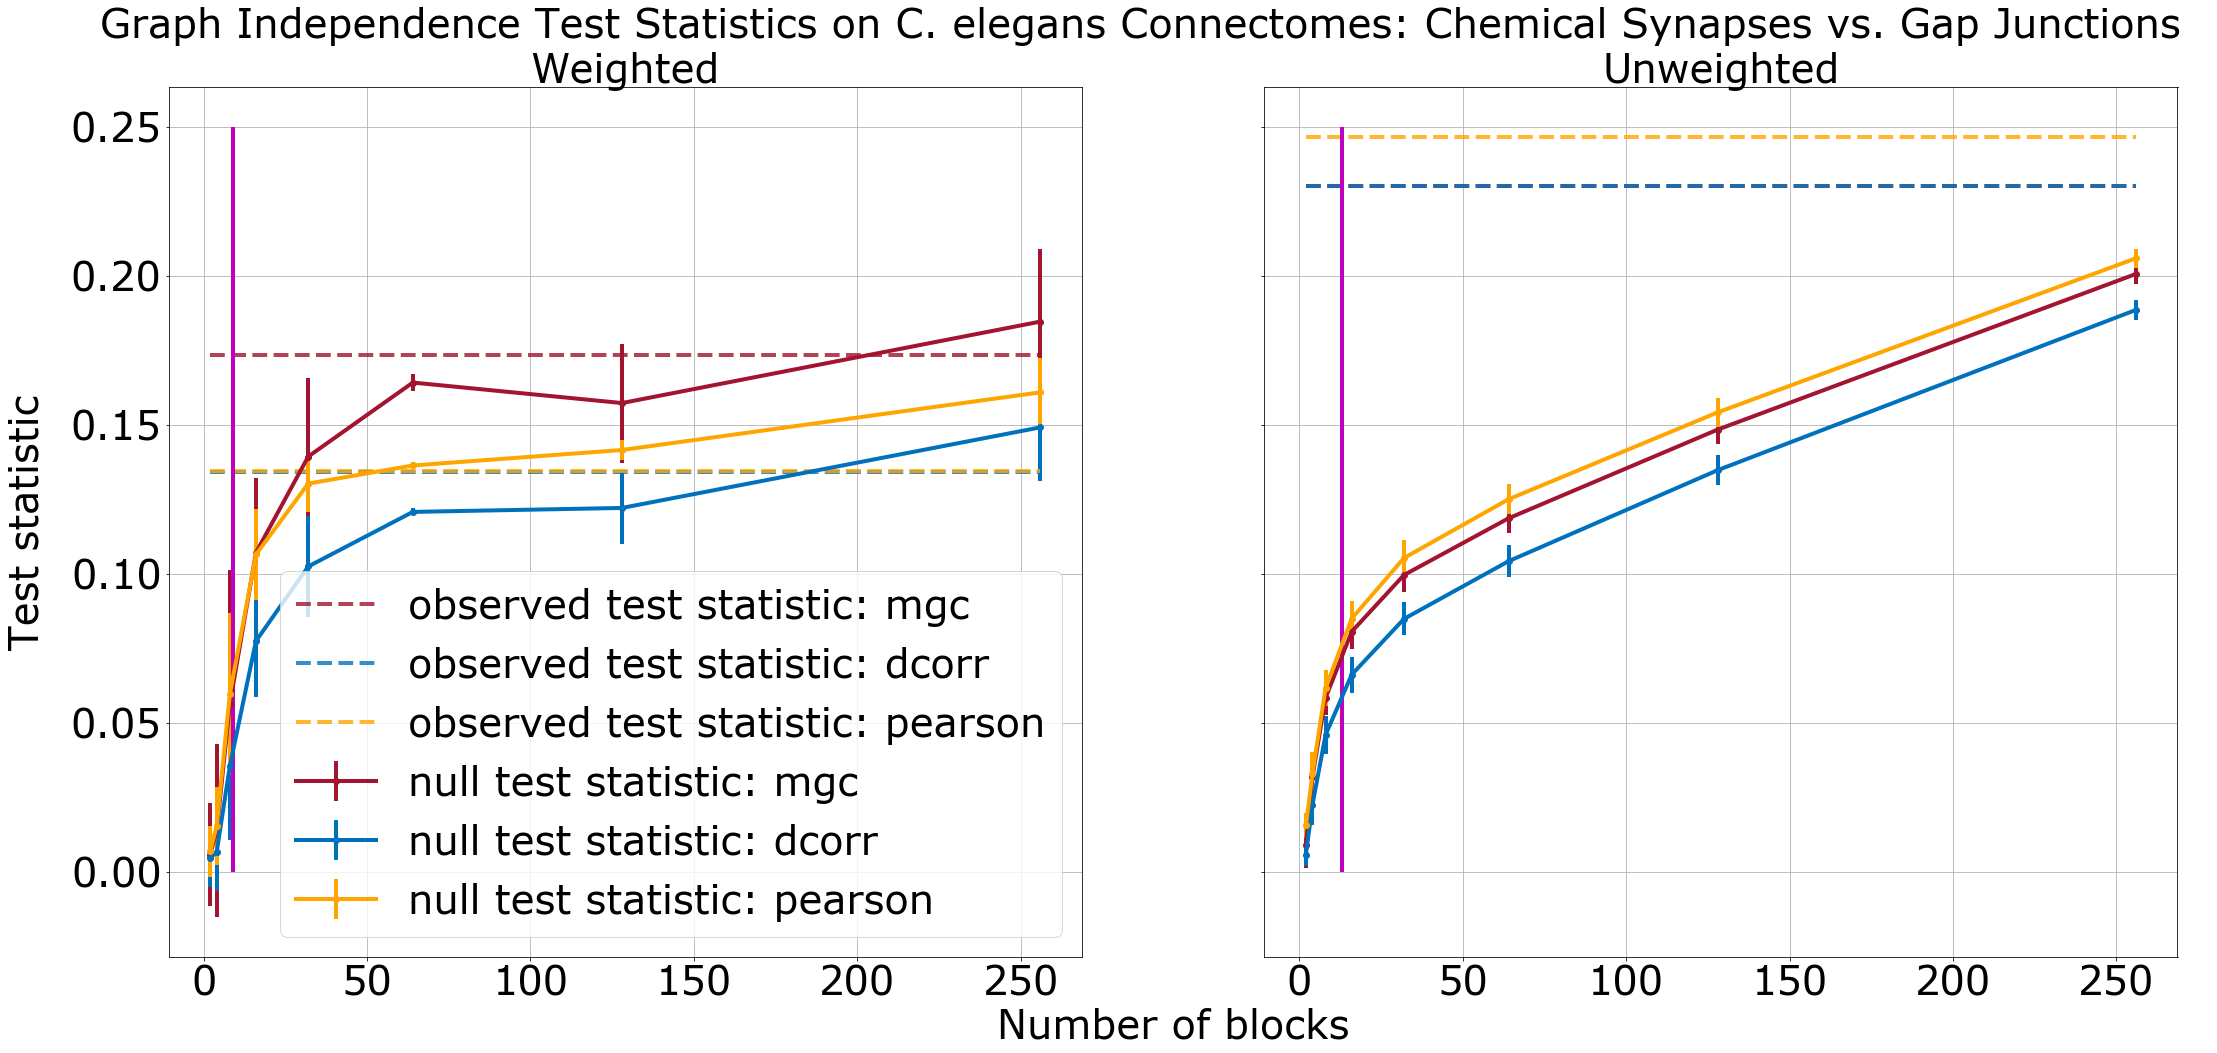

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(36, 16), squeeze=True, sharex=True, sharey=True)
axs = axs.reshape(-1)
k_arr = np.logspace(start=1, stop=8, num=8, base=2, dtype=int)

test_names = ['mgc', 'dcorr', 'pearson']

for name in test_names:
    test_stats_null_arr = load_arr(name, weighted=True)
    if name == 'mgc':
        test = MGC(compute_distance_matrix=identity)
        test_stats_alt, _ = test.test_statistic(to_distance_mtx(chem), to_distance_mtx(gap))
    elif name == 'dcorr':
        test = DCorr(compute_distance_matrix=identity)
        test_stats_alt, _ = test.test_statistic(to_distance_mtx(chem), to_distance_mtx(gap))
    elif name == 'pearson':
        test = RVCorr(which_test='pearson')
        test_stats_alt, _ = test.test_statistic(triu_no_diag(chem), triu_no_diag(gap))
    axs[0].hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), 
                  label='observed test statistic: {}'.format(name), color=colors[name], alpha=0.8,
                 linewidth=lw, linestyle='--')
    axs[0].errorbar(k_arr, np.mean(test_stats_null_arr, axis=1), yerr=np.std(test_stats_null_arr, axis=1), 
                 color=colors[name], marker='o', linestyle='-', label='null test statistic: {}'.format(name),
                   linewidth=lw)
axs[0].legend(loc=4, prop={'size': legend_size})
axs[0].vlines(x=9, ymin=0, ymax=0.25, label='the BIC estimated k', colors='m', linewidth=lw)
axs[0].grid()

for name in test_names:
    test_stats_null_arr = load_arr(name, weighted=False)
    if name == 'mgc':
        test = MGC(compute_distance_matrix=identity)
        test_stats_alt, _ = test.test_statistic(to_distance_mtx(chem_uw), to_distance_mtx(gap_uw))
    elif name == 'dcorr':
        test = DCorr(compute_distance_matrix=identity)
        test_stats_alt, _ = test.test_statistic(to_distance_mtx(chem_uw), to_distance_mtx(gap_uw))
    elif name == 'pearson':
        test = RVCorr(which_test='pearson')
        test_stats_alt, _ = test.test_statistic(triu_no_diag(chem_uw), triu_no_diag(gap_uw))
    axs[1].hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), 
                  label='observed test statistic: {}'.format(name), color=colors[name], alpha=0.8,
                 linewidth=lw, linestyle='--')
    axs[1].errorbar(k_arr, np.mean(test_stats_null_arr, axis=1), yerr=np.std(test_stats_null_arr, axis=1), 
                 color=colors[name], marker='o', linestyle='-', label='null test statistic: {}'.format(name),
                   linewidth=lw)
axs[1].vlines(x=13, ymin=0, ymax=0.25, label='the BIC estimated k', colors='m', linewidth=lw)
axs[1].grid()

pad = 5
cols = ['Weighted', 'Unweighted']
for ax, col in zip(axs, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=label_size, ha='center', va='baseline')

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Number of blocks', fontsize=label_size)
plt.ylabel('Test statistic', fontsize=label_size, labelpad=50)
fig.suptitle('Graph Independence Test Statistics on C. elegans Connectomes: Chemical Synapses vs. Gap Junctions', 
             fontsize=label_size, y=0.95)
plt.savefig('../../figures/all_celegans_ts.png', bbox_inches='tight')

In [98]:
block_assignment = estimate_block_assignment(chem, gap, k=256, set_k=False, num_repeats=10)

In [99]:
np.unique(block_assignment).size

9

In [103]:
test = DCorr(compute_distance_matrix=identity)
test.p_value(to_distance_mtx(chem), to_distance_mtx(gap))

(0.0, {})

In [112]:
test.get_name()

'unbiased'